In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3, 2)  #set default figure size

import quantecon as qe

## Contents
- [Introduction](#introduction)
- [Example and DSDP Representation](#example-and-dsdp-representation)
- [Value Iteration](#value-iteration)
    - [Program by Hand](#program-by-hand)
    - [Simulation by policy function](#2-monte-carlo-simulation-of-states-actions-and-rewards)
    - [Program with quantecon](#program-of-quantecon)
- [Policy Iteration](#policy-iteration)
    - [Program by hand](#program-by-hand)
    - [Program with quantecon](#program-with-quantecon)

## Introduction

In the previous lecture, we studied the structure of Dynamic Stochastic Discrete Programming (DSDP) and the properties of the value function. Additionally, we briefly introduced the principles of two algorithms, **Value Iteration** and **Policy Iteration**, based on the characteristics of the value function.

To further deepen our understanding of these algorithms, in this lecture, we will practice both algorithms using a more generalized model than the McCall search model.

For each algorithm, we will first implement it through manual programming and then apply the `quantecon` package to achieve the same. 

The reason for learning the `quantecon` package is that it leverages `numba` to enhance computational speed, making it more suitable for larger and more complex models.


## Example and DSDP Representation

Unlike the simple setup of the McCall model, in our example, the state transition probability depends on both the individual's current state and their action.

In our model, the individual:
- Has two **states** $s \in S$:  
    $$
    S := \{0, 1\}, \\
    n := \#(S) = 2
    $$

- We assume that in any state, there are two **feasible actions** $A(s)$:  
    $$
    A(s=0) := \{0, 1\} \\
    A(s=1) := \{0, 1\} \\
    m := \#(A(s)) = 2
    $$

- Therefore, the set of any feasible state-action pairs $SA$ contains $n \times m$ elements:  
    $$
    SA := \{(s, a) \mid s \in S, a \in A(s)\} \\
    = \{(0, 0), (1, 0), (0, 1), (1, 1)\}
    $$

- The **reward array** $Ra$ is defined by a $n \times m$ array, representing the immediate reward for choosing action $a$ in state $s$:  
    $$
    Ra := 
    \begin{pmatrix}
    1 & 0 \\ 
    0 & 1.1
    \end{pmatrix}
    $$
    Here, each row represents a state $s$, and each column represents an action $a$.  
    Therefore, each element of the reward array is a projection of the reward function $R: SA \to \mathbb{R}$:
    $$
    Ra(i,j) := R(s=i, a=j)
    $$

- The **transition probability array** $Qa$ is a $n \times m \times n$ array.  
    - The first dimension represents the current state $s \in S$.
    - The second dimension represents an action $a \in A(s)$.
    - The third dimension represents the possible next state $s' \in S$.  
    Thus, each element of the transition probability array is a projection of the transition probability $Q: SA \to \Delta(S)$:
    $$
    Qa(i,j,k) := Q(s=i, a=j, s'=k)
    $$  
    - Since $Q$ is a probability matrix, $Qa$ must satisfy the following two conditions:  
        $$ 
        \sum_{s' \in S} Qa(s,a,s') = 1 \\
        Qa(s,a,s') > 0, \forall s, a, s'
        $$

> **Note**
>
> - We can embed feasibility constraints into $R$ by setting $R[s, a] = -\infty$ for $a \notin A(s)$.  
> - Probability distributions for $(s, a)$ with $a \notin A(s)$ can be arbitrary.


Next, we will encapsulate these settings into a class. 

(We use a class structure to facilitate the use of the `Quantecon` package.)

In [3]:
class Example:
    def __init__(self,n=2,m=2,β=0.9):
        """
        Set up R, Q and β, the three elements that define an instance of
        the DiscreteDP class.  

        n (int): Number of elements in state set, S  
        m (int): Number of elements in feasible action set, A  
        β (float): discount factor  
        """
        self.n, self.β, self.m = n, β, m
        self.R = np.zeros((n,m))
        self.Q = np.zeros((n,m,n))
    
    def populate_R(self):
        """
        Populate the R matrix, with R[s, a] = -np.inf for infeasible
        state-action pairs.
        """
        self.R = np.array([
            [1, 0],  # in state 0, reward of choose action 0 and 1
            [0, 1.1],  # in state 1, reward of choose action 0 and 1
            ])
    
    def populate_Q(self):
        """
        Populate the Q matrix
        """
        self.Q = np.array([
            [[0.7, 0.3], [0.6, 0.4]],  # in state 0, after choose action 0,1, transition prob to state 0,1.
            [[0.4, 0.6], [0.3, 0.7]],  # in state 1, after choose action 0,1, transition prob to state 0,1.
            ])
    
    def state_action_values(self,s,V):
        """
        The values of state-action pairs, given arbitrary value function.
        (Function for value iteration)
        (Not necessary for quantecon)
        """
        β, R, Q, n, m = self.β, self.R, self.Q, self.n, self.m
        state_action_value = np.zeros(m)
        for a in range(m):
            state_action_value[a] = R[s,a] + β * np.sum(Q[s, a, :] * V)
        return state_action_value
    
    def policy_evaluation(self, policy, V, ε=1e-6, max_iter=500):
        """
        Evaluate the value of a given policy
        (Function for policy iteration)
        (Not necessary for quantecon)
        """
        β, R, Q, n, m = self.β, self.R, self.Q, self.n, self.m
        # Initialize the iteration
        ii=0
        dif = 10
        V_next = np.zeros_like(V)
        
        while ii<max_iter and dif>ε:
            for s in range(n):
                a=policy[s]
                V[s] = R[s, a] + β * np.sum(Q[s, a, :] * V)
            
            dif=max(abs(V-V_next))
            V_next[:]=V
            ii += 1
        
        return V

Let’s run this code and create an instance of `Example`.

In [4]:
# Initialize the model
ex = Example()
ex.populate_R()
ex.populate_Q()

print(f'The discount factor is: \n {ex.β}')
print(f'The reward array is: \n {ex.R}')
print(f'The transition probabiliry array is: \n {ex.Q}')

The discount factor is: 
 0.9
The reward array is: 
 [[1.  0. ]
 [0.  1.1]]
The transition probabiliry array is: 
 [[[0.7 0.3]
  [0.6 0.4]]

 [[0.4 0.6]
  [0.3 0.7]]]


## Value Iteration

### Algorithm:  
1. Choose any $ v^0 \in \mathbb{R}^n $, and specify $ \varepsilon > 0 $; set $ i = 0 $.  
1. Compute $ v^{i+1} = T v^i $.  
1. If $ \lVert v^{i+1} - v^i\rVert <  [(1 - \beta) / (2\beta)] \varepsilon $,
  then go to step 4; otherwise, set $ i = i + 1 $ and go to step 2.  
1. Compute a $ v^{i+1} $-greedy policy $ \sigma $, and return $ v^{i+1} $ and $ \sigma $.  


### Program by Hand

- First, we will solve this optimization problem using a custom value function iteration function to obtain the optimal value function $v^*$ and the policy function $\sigma: S \to A$.
- Second, we will perform a **Monte Carlo simulation** on the model to observe how states and actions change within the transition matrix.
- Finally, by extending the simulation over a long period, we can derive the **stationary distribution of the states**.


#### 1. Value function iteration

In [5]:
def value_iteration(ex,max_iter=500,ε=1e-5,show_converge=True):

    # Initialize value function
    V = np.zeros(ex.n)+0.1
    V_next = np.zeros_like(V)
    
    # Initialize iteration
    policy = np.zeros(ex.n, dtype=int)
    dif=20
    iter=0

    # Iteration
    while iter<max_iter and dif>ε:
        
        for j in range(ex.n):
            V_next[j] = max(ex.state_action_values(j,V))
            policy[j] = np.argmax(ex.state_action_values(j,V))
        
        dif = np.max(np.abs(V-V_next))
        iter += 1
        V[:]=V_next
        
        if show_converge==True:
            if iter%40 == 0 or dif < 1e-5:
                print(f'iteration: {iter}, error: {dif}')
            if dif < 1e-5:
                print('value function converged successfully')
    
    return V,policy

Now, let's try running this program:

iteration: 40, error: 0.01708013139898945
iteration: 80, error: 0.00025245942283369516
iteration: 111, error: 9.631842617707775e-06
value function converged successfully


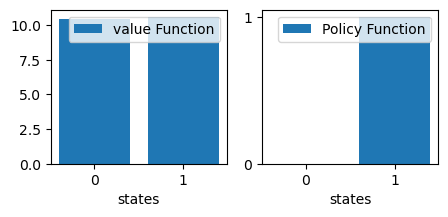

In [6]:
# Initialize the model
ex = Example()
ex.populate_R()
ex.populate_Q()

# value funciton iteration
value_fun,policy_fun=value_iteration(ex)

# draw the graph
states = np.array([0,1])
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

axs[0].bar(states, value_fun, label="value Function")
axs[0].set_xlabel('states')
axs[0].set_xticks([0,1])
axs[0].legend()

axs[1].bar(states, policy_fun, label="Policy Function")
axs[1].set_xlabel('states')
axs[1].set_xticks([0,1])
axs[1].set_yticks([0,1])
axs[1].legend()
plt.show()

#### 2. Monte Carlo Simulation of States, Actions, and Rewards

Through Monte Carlo simulation, we can calculate the changes in states and individual actions from any initial state.  

Additionally, by simulating the time series, we can also determine the long-term stationary distribution of the states.

In [7]:
def montecarlo(ex,T,policy,initial_state=0,seed=1234):
    state_sequence = np.zeros(T, dtype=int)
    action_sequence = np.zeros(T, dtype=int)
    reward_sequence = np.zeros(T)

    state_sequence[0] = initial_state
    np.random.seed(seed)
    
    for t in range(T - 1):
        current_state = state_sequence[t]
        
        # decide action by policy function
        action = policy[current_state]
        action_sequence[t] = action

        # calculate reward
        reward_sequence[t] = ex.R[current_state, action]

        # random choice of next state by state transition probability
        next_state = np.random.choice(ex.n, p=ex.Q[current_state, action, :])
        state_sequence[t + 1] = next_state
    
    # Final period action and reward 
    action_sequence[-1] = policy[state_sequence[-1]]
    reward_sequence[-1] = ex.R[state_sequence[-1], action_sequence[-1]]

    return state_sequence, action_sequence, reward_sequence

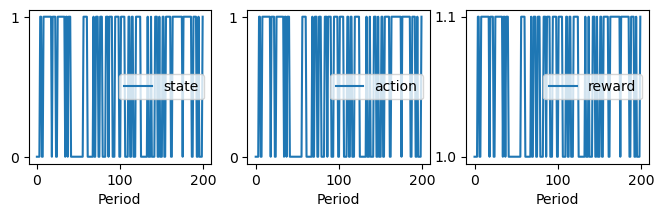

In [8]:
T=200
state_sequence, action_sequence, reward_sequence =  montecarlo(ex,T,policy_fun,initial_state=0,seed=1234)

# draw the graph
time = np.arange(T)
fig, axs = plt.subplots(1, 3, figsize=(8, 2))

axs[0].plot(time, state_sequence, label="state")
axs[0].set_xlabel('Period')
axs[0].set_yticks([0,1])
axs[0].legend()

axs[1].plot(time, action_sequence, label="action")
axs[1].set_xlabel('Period')
axs[1].set_yticks([0,1])
axs[1].legend()


axs[2].plot(time, reward_sequence, label="reward")
axs[2].set_xlabel('Period')
axs[2].set_yticks([1, 1.1])
axs[2].legend()
plt.show()

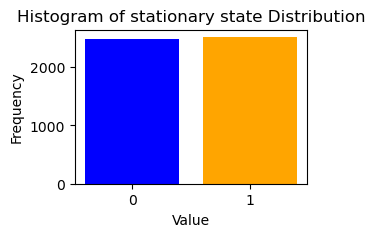

In [9]:
state_sequence,_,_ =  montecarlo(ex,5000,policy_fun,initial_state=0,seed=1234)

unique, counts = np.unique(state_sequence, return_counts=True)
plt.bar(unique, counts, color=['blue', 'orange'])
plt.title('Histogram of stationary state Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.show()

### Program with `quantecon`

`quantecon` provides us with a high-speed value function iteration tool.  
(The prerequisite is that we correctly define the reward function $R$ and the state transition matrix $Q$.)


Instances of `DiscreteDP` are created using the signature `DiscreteDP(R, Q, β)`.

Let’s create an instance using the objects stored in `ex`

In [10]:
# Initialize the model
ex = Example()
ex.populate_Q()
ex.populate_R()

ddp = qe.markov.DiscreteDP(ex.R, ex.Q, ex.β)

Now that we have an instance `ddp` of `DiscreteDP` we can solve it as follows

In [11]:
results = ddp.solve(method='value_iteration')
print(f'Elements of results: \n {dir(results)}') 
print(f'\n Method: {results.method}') 
print(f'\n Value function: {results.v}')
print(f'\n Policy function: {results.sigma}')
print(f'\n Stationary distribution of state: {results.mc.stationary_distributions}')
print(f'\n Times of literation: {results.num_iter}')
print('\n')
print(f'Converge criteria: {results.epsilon}')
print(f'\n Max limit of literation: {results.max_iter}')

Elements of results: 
 ['epsilon', 'max_iter', 'mc', 'method', 'num_iter', 'sigma', 'v']

 Method: value iteration

 Value function: [10.42140269 10.57765269]

 Policy function: [0 1]

 Stationary distribution of state: [[0.5 0.5]]

 Times of literation: 94


Converge criteria: 0.001

 Max limit of literation: 250


## Policy Iteration

### Algorithm:
1. Choose any $v^0 \in \mathbb{R}^n$ and compute a $v^0$-greedy policy $\sigma^0$; set $i = 0$.  
2. Compute the value $v_{\sigma^i}$ by solving the equation $v = T_{\sigma^i} v$.  
3. Compute a $v_{\sigma^i}$-greedy policy $\sigma^{i+1}$; let $\sigma^{i+1} = \sigma^i$ if possible.  
4. If $\sigma^{i+1} = \sigma^i$, then return $v_{\sigma^i}$ and $\sigma^{i+1}$; otherwise, set $i = i + 1$ and go to step 2.

Thus, implementing this algorithm requires two steps: **Policy Evaluation** and **Policy Improvement**.  
- In Policy Evaluation, the value function for policy $v_\sigma$  is computed given an initial policy $\sigma$.
- In Policy Improvement, the policy $\sigma$ is updated by optimal choices of $v_\sigma$ until the policy function converges.

### Program by hand

In [12]:
def policy_iteration(ex,max_iter=500):
    # Definition
    β, R, Q=ex.β, ex.R, ex.Q

    # Initialize the iteration
    iter=0
    policy = np.zeros(ex.n, dtype=int)
    V = np.zeros(ex.n)

    is_policy_stable = False
    while not is_policy_stable and iter<max_iter:
        # Policy evaluation
        V = ex.policy_evaluation(policy, V)
    
        # Policy improvement
        is_policy_stable = True
        for s in range(ex.n):
            old_action = policy[s]
            action_values = np.zeros(ex.m)
            
            for a in range(ex.m):
                action_values[a] = R[s, a] + β * np.sum(Q[s, a, :] * V)
            
            best_action = np.argmax(action_values)
            policy[s] = best_action
        
            if old_action != best_action:
                is_policy_stable = False
        iter += 1
    return V, policy

In [13]:
# Initialize the model
ex = Example()
ex.populate_Q()
ex.populate_R()

V,policy = policy_iteration(ex,max_iter=500)
print(f'Value function: {V}')
print(f'Policy function: {policy}')
print('The result is equal to the value function iteration')

Value function: [10.42186755 10.578118  ]
Policy function: [0 1]
The result is equal to the value function iteration


### Program of `quantecon`

In [14]:
# Initialize the model
ex = Example()
ex.populate_Q()
ex.populate_R()

# Define the discrete dynamic programming problem
ddp = qe.markov.DiscreteDP(ex.R, ex.Q, ex.β)

results = ddp.solve(method='policy_iteration')
print(f'Elements of results: \n {dir(results)}') 
print(f'\n Method: {results.method}') 
print(f'\n Value function: {results.v}')
print(f'\n Policy function: {results.sigma}')
print(f'\n Stationary distribution of state: {results.mc.stationary_distributions}')
print(f'\n Times of literation: {results.num_iter}')
print('\n')
print(f'\n Max limit of literation: {results.max_iter}')

Elements of results: 
 ['max_iter', 'mc', 'method', 'num_iter', 'sigma', 'v']

 Method: policy iteration

 Value function: [10.421875 10.578125]

 Policy function: [0 1]

 Stationary distribution of state: [[0.5 0.5]]

 Times of literation: 1



 Max limit of literation: 250
